# Libraries
Please check the dependencies, this notebook was written to be used with Python 11. Also, download the file `'water features map.npy'`.

In [1]:
import math
import pickle
import warnings
import os 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

from scipy.spatial.transform import Rotation as Rot
from scipy import signal
from scipy.interpolate import interp2d, RegularGridInterpolator
from scipy.optimize import NonlinearConstraint, LinearConstraint

import statsmodels.api as sm
from IPython.display import clear_output

### Random Seed

In [2]:
seed = 12345 
np.random.seed(seed)
results_name = 'long_sinusoidal_yaw'
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'STIXGeneral', 'mathtext.fontset':'cm'})

## Water feature maps
Loads the water maps and shows our Region of Interest at Biscayne Bay.


Grid shape: (98, 155, 8, 4)
Dissolved Oxygen = 0
Chlorophyll = 1
Temperature = 2
Turbidity = 3

 
- Each pixel corresponds to a square whose side's length is 10 meters. 
- z must belong to the interval [0,4] and be an integer.
- the pair x,y should belong to the set [0,980]x[0,1550] and can be real numbers.



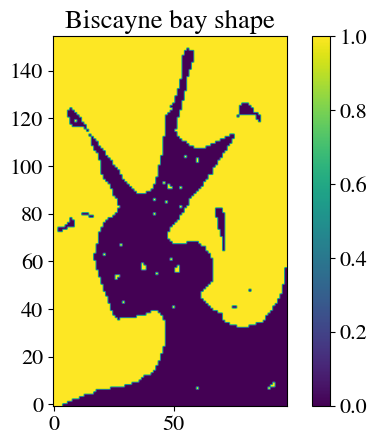

In [3]:
feature_maps = np.load('water features map.npy')
print('Grid shape:',feature_maps.shape )
width,height , depth, n_features = feature_maps.shape

print(
'''Dissolved Oxygen = 0
Chlorophyll = 1
Temperature = 2
Turbidity = 3
''')

feature_maps_list = [feature_maps[:, :, :, i] for i in range(n_features)]
Biscayne_map = (feature_maps[:,:,0,1]==0).T # Top layer
plt.imshow(Biscayne_map)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Biscayne bay shape")

x_coordenates, y_coordenates, z_coordenates = np.arange(0, 10*width,10 ), np.arange(0, 10*height,10 ), np.arange(0,depth,1)

print(f''' 
- Each pixel corresponds to a square whose side's length is 10 meters. 
- z must belong to the interval [0,{4}] and be an integer.
- the pair x,y should belong to the set [0,{10*width}]x[0,{10*height}] and can be real numbers.
''')

## Water features
Interpolates water features using `interp_method` (`'linear'`, `'cubic'`, etc.). The variables `coef_chloro`, `coef_do`, `coef_temp`, `coef_turb` act as regularization constrains 
to build a fused functional. `measurement_noise_sigma` is the standard deviation of the noise applied to simulate the sampling process.

In [4]:
interp_method = 'linear'
coef_chloro, coef_do, coef_temp, coef_turb = [1.0, 1.0, 0.0, 0.5]
measurement_noise_sigma = 0.1

quality_interpolators = [RegularGridInterpolator( [x_coordenates, y_coordenates, z_coordenates], feature_values, method = interp_method) for feature_values in feature_maps_list]

def measure_gen(water_feature):
    def function(x):
        x_mod = np.copy(np.reshape(x, (x.size,))[0:3])
        x_mod[-1] = np.abs(x_mod[-1])
        return water_feature(x_mod)
    return function
        
dissolved_oxygen,  chlorophyll, temperature, turbidity = [measure_gen(quality_interpolator) for quality_interpolator in quality_interpolators]

def corrupted_chlorophyll(x,sigma = measurement_noise_sigma):
    return chlorophyll(x)+ sigma*np.random.randn()

def corrupted_dissolved_oxygen(x,sigma = measurement_noise_sigma):
    return dissolved_oxygen(x)+ sigma*np.random.randn()

def corrupted_temperature(x,sigma = measurement_noise_sigma):
    return temperature(x)+ sigma*np.random.randn()

def corrupted_turbidity(x,sigma = measurement_noise_sigma):
    return turbidity(x)+ 40*sigma*np.random.randn()

print(f'Chlorophyll testmeasurement: Corrupted {corrupted_chlorophyll(np.array([400,600,-2]))[0]} real {chlorophyll(np.array([400,600,-2]))[0]}')
print(f'Temperature test measurement: Corrupted {corrupted_temperature(np.array([400,600,-2]))[0]} real {temperature(np.array([400,600,-2]))[0]}')


Chlorophyll testmeasurement: Corrupted 8.806594203499898 real 8.827064969448369
Temperature test measurement: Corrupted 27.217748247224836 real 27.169853913419082


## Histograms
Q-Q plots built using the normalized data, it shows that the data are aproximated by a log-normal distribution.

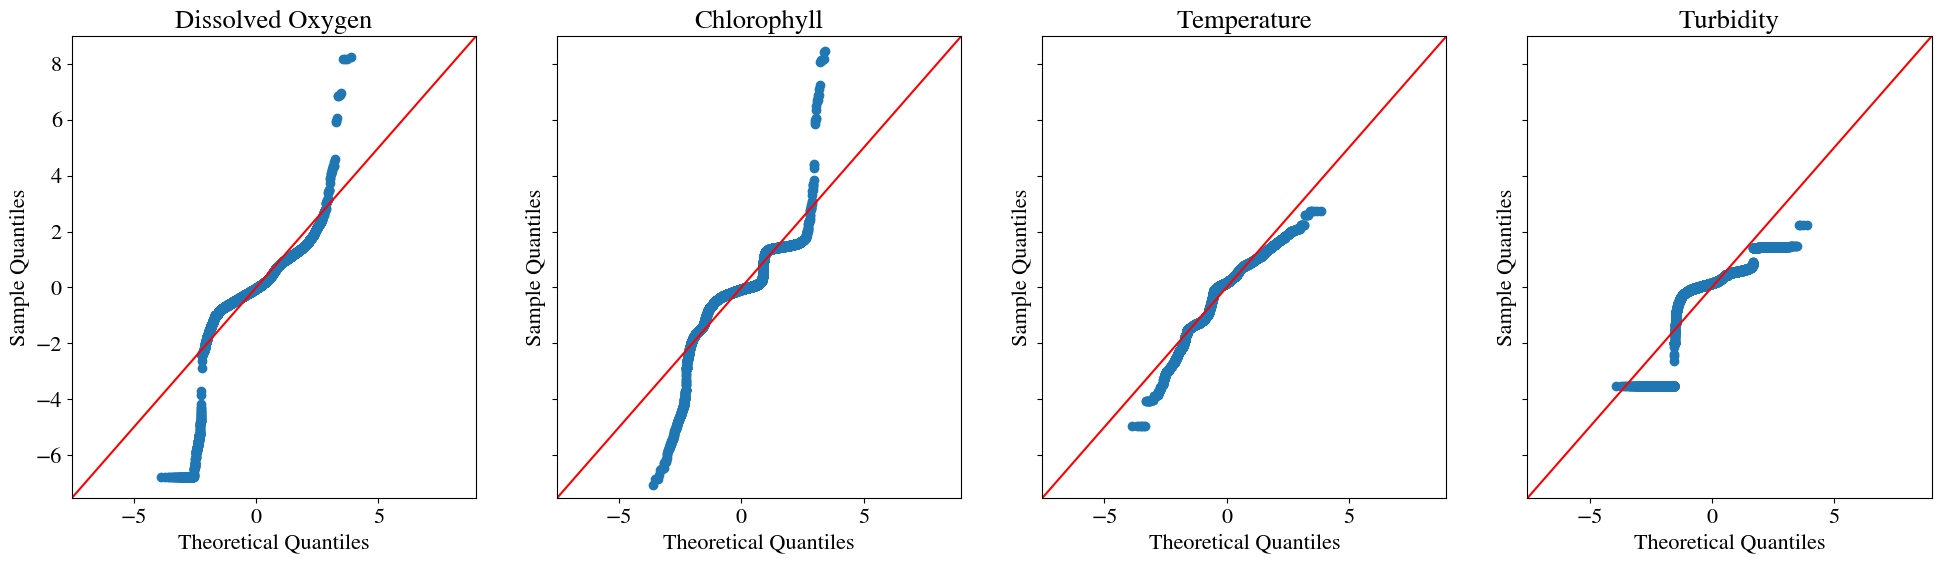

In [5]:
Water_features_dict = {0 : 'Dissolved Oxygen', 1 : 'Chlorophyll', 2 : 'Temperature', 3 : 'Turbidity'}

fig, axs = plt.subplots(1,4, figsize = (24, 6), sharey = True)
for i, ax in zip(range(4), axs.flatten()):
    data = feature_maps[:,:,:,i].flatten()
    data = np.log(data[data!=0])
    data = (data-np.mean(data))/np.std(data)
    _=sm.qqplot(data, line='45', ax =ax)
    ax.set_title(Water_features_dict[i])

## Covariances
Implements covariances matrices taking into account the robot's depth to increase the uncertainity.

In [6]:
# Q = state covariance matrix (4x4)
# variance for location x-axis, location y-axis, yaw angle, velocity
# State Vector [x y z yaw v]'
Q = np.diag([        
  1.0,
  1.0,
  1.0,
  np.deg2rad(1.0),
  1.0
])**2


# R = observation covariance matrix (3x3)
# variance for observation in position x, y, z. Flag indicates whether using the GPS or the clorophyll covariance matrix.
def R(x,flag):
    depth = abs(x[2])
    if flag:
        return 1*np.diag([1.0, 1.0, 1.0])
    else:
        #Uncertainty should increase when depth increases
        return 1*(1.0+0.1*depth)*np.diag([1.0, 1.0, 1.0])

# Function `motion_model(x, u)`
Performs the robot's motion model given a state `x` and action `u`.

In [7]:
"""
x = State Vector [x y z yaw v]'
u = Control vector [v u_z omega]
motion model
    x_{t+1} = x_t + v * dt * cos(yaw)
    y_{t+1} = y_t + v * dt * sin(yaw)
    z_{t+1} = z_t + u_z * dt
    yaw_{t+1} = yaw_t + omega*dt
    v_{t+1} = v{t}
"""
def motion_model(x, u):
    F = np.array([
                [1, 0, 0, 0, 0], # x, y, z, yaw, v
                [0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0]
    ])

    B = np.array([
                [DT * math.cos(x[3, 0]), 0, 0],
                [DT * math.sin(x[3, 0]), 0, 0],
                [0, DT, 0],
                [0, 0, DT],
                [1.0, 0, 0],
    ])

    x = F @ x + B @ u
    return x

# Function (Underwater) `observation_model(x)` 
Estimates the state given measurements at the point and SDUE maps. For details see (Fuentes J. 2022 Localization in Seemingly Sensory-Denied Environments through Spatio-Temporal Varying Fields)


In [8]:
# Water fea Sensor 
#optimization part, takes a while


'''per water feature'''
def water_params_loc_estimation(state , measurements=None , radii= 1*np.array([4,4,0.5]),  opt_mode = 'fast'):
    assert state.shape == (5,)
    center = state[:3]
    if measurements==None:
        cl_measurement = corrupted_chlorophyll(center)
        do_measurement = corrupted_dissolved_oxygen(center)
        temp_measurement = corrupted_temperature(center)
        turb_measurement = corrupted_turbidity(center)
    else:
        cl_measurement, do_measurement, temp_measurement, turb_measurement = measurements
    
    constraint = lambda x: np.sum((np.abs(x-center)**2)/(radii**2))
    
    clorophyll_difference = lambda x:  np.power(np.abs(chlorophyll(x)-cl_measurement), 1)
    dissolved_oxygen_difference = lambda x:  np.power(np.abs(dissolved_oxygen(x)-do_measurement), 1)
    temperature_difference = lambda x:  np.power(np.abs(temperature(x)-temp_measurement), 1)
    turbidity_difference = lambda x:  np.power(np.abs(turbidity(x)-turb_measurement), 1)
    

    def functional(x):
        return coef_chloro*clorophyll_difference(x)+ coef_do*dissolved_oxygen_difference(x) + coef_temp*temperature_difference(x) + coef_turb*turbidity_difference(x)

    
    bounds = [(0, 10*(width-1)), (0, 10*(height-1)), (-depth+1.0,0)]
    # two ways to obtain the position usnig the given the SDUE map, a point and a radius
    if opt_mode =='slow':
        # slower, seems to be more reliable
        position = scipy.optimize.differential_evolution(functional,bounds = bounds, constraints = NonlinearConstraint(constraint, 0, 1), maxiter=2000 )

    elif opt_mode =='fast':
        # faster, doesn't seem as reliable as before
        Non_linear_constraint, Linear_constraint = NonlinearConstraint(constraint, 0, 1), LinearConstraint(np.eye(3),[0,0,-depth+1],[10*(width-1), 10*(height-1), 0],keep_feasible=False)
        position = scipy.optimize.minimize(functional,x0 = center, bounds = bounds,
                                           constraints = (Non_linear_constraint, Linear_constraint),
                                            method= 'COBYLA'  )
    return position.x

print(f'Example: real location {np.array([400,600,-2.0, np.pi, 2][:3])} estimated {water_params_loc_estimation(np.array([400,600,-2.0, np.pi, 2]))}')

Example: real location [400. 600.  -2.] estimated [400.5114748  600.87368407  -1.9580866 ]


/lclhome/jfuen099/anaconda3/envs/Python11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


# Function `observation_model(x)`
Estimates the `observation_model(x)` and its Jacobian using a finite--difference scheme.

In [9]:
# State Vector [x y z yaw v]'
def observation_model(x,kwargs={}):
    z = np.reshape(x, (x.size,))
    z = water_params_loc_estimation(z,**kwargs)
    return np.reshape(z, (z.size,1))

In [10]:
def jac_water_params_loc_estimation(x,h=np.array([5,5,0.2]), kwargs={}): #x is the state vector
    assert x.shape == (5,)
    jacobian = np.zeros((3,5))
    for i in range(3):
        e_i = np.zeros((5,))
        e_i[i] = h[i]
        col_i = (observation_model(x +e_i,kwargs) - observation_model(x -e_i,kwargs ) )/(2*h[i]) 
        jacobian[:3,i] = col_i.flatten()
    return jacobian
jac_water_params_loc_estimation(np.array([440,660,-2.0, np.pi, 2]))

/lclhome/jfuen099/anaconda3/envs/Python11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/lclhome/jfuen099/anaconda3/envs/Python11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/lclhome/jfuen099/anaconda3/envs/Python11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/lclhome/jfuen099/anaconda3/envs/Python11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/lclhome/jfuen099/anaconda3/envs/Python11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %

array([[ 1.19701015, -0.20602514, -4.96042551,  0.        ,  0.        ],
       [-0.08934816,  1.02847515,  0.67479973,  0.        ,  0.        ],
       [ 0.02803334,  0.04103412,  0.9265249 ,  0.        ,  0.        ]])

# Function `observation(xTrue, xDR, u)`
Emulates a complete observation and executes one action on the agent (aka robot).

In [11]:
def observation(xTrue, xDR, u):
    # add noise to input
    ud = u + INPUT_NOISE @ np.random.randn(3, 1)

    # add noise to gps x-y
    z = observation_model(xTrue) + SENSOR_NOISE @ np.random.randn(3, 1)

    # Dead reckoning (with noise)
    xDR = motion_model(xDR, ud) 

    # True state values, no noise
    xTrue = motion_model(xTrue, u) 

    return xTrue, z, xDR, ud

# Function `jacob_f(x, u)`
Estimates the Jacobian of the robot's dynamics.

In [12]:
"""
    Jacobian of Motion Model
    State Vector [x y z yaw v]'
    
    motion model
    x_{t+1} = x_t + v * dt * cos(yaw)
    y_{t+1} = y_t + v * dt * sin(yaw)
    z_{t+1} = z_t + u_z * dt
    yaw_{t+1} = yaw_t + omega*dt
    v_{t+1} = v{t}

    so
    dx/dx   = 1
    dx/dy   = 0
    dx/dz   = 0
    dx/dyaw = -v * dt * sin(yaw)
    dx/dv   = dt * cos(yaw)

    dy/dx   = 0
    dy/dy   = 1
    dy/dz   = 0
    dy/dyaw = v * dt * cos(yaw)
    dy/dv   = dt*sin(yaw)

    dz/dx   = 0
    dz/dy   = 0
    dz/dz   = 1
    dz/dyaw = 0
    dz/dv   = 0

    dyaw/dx   = 0
    dyaw/dy   = 0
    dyaw/dz   = 0
    dyaw/dyaw = 1
    dyaw/dv   = 0

    dv/dx   = 0
    dv/dy   = 0
    dv/dz   = 0
    dv/dyaw = 0
    dv/dv   = 1
    """

def jacob_f(x, u):
    yaw = x[3, 0]
    v   = u[0, 0]
    u_z = u[1, 0]

    jF = np.array([
                 [1, 0, 0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
                 [0, 1, 0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1]
    ])

    return jF

# Function `jacob_h(x, flag)`
Estimates the Jacobian of the robot's dynamics adding the GPS availability constrain.

In [13]:
# Jacobian of Observation Model
def jacob_h(x=0, flag=True): #flag 
    x = np.reshape(x,(5,))
    if flag: # depth, gps signal doesn't work well below 2 ft. 
        jH = np.array([
                        [1, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0],
                        [0, 0, 1, 0, 0]])
        print('Jacobian using GPS')
    else: #using SDUE multiple sensors
        jH = jac_water_params_loc_estimation(x)
        print('Jacobian using SDUE')

    return jH

# Function `ekf_estimation(xEst, PEst, z, u)`
Performs one step EKF estimation.

In [14]:
def ekf_estimation(xEst, PEst, z, u, flag):
    # Predict
    xPred = motion_model(xEst, u)
    jF = jacob_f(xEst, u)
    PPred = jF @ PEst @ jF.T + Q

    # Update
    jH = jacob_h(xEst, flag)
    zPred = observation_model(xPred)

    assert z.shape == zPred.shape  
    y = z - zPred # residual
    S = jH @ PPred @ jH.T + R(xEst,flag)
    K = PPred @ jH.T @ np.linalg.inv(S) # Kalman Gain
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jH) @ PPred

    return xEst, PEst, Q, R

# Simulation parameters

In [15]:
INPUT_NOISE = 1.25*np.diag([0.5, 0.5, np.deg2rad(3.0)])**2 # actuator noise (propeller and fin)
SENSOR_NOISE = 0.01*np.diag([0.1, 0.1, 0.1])**2 # sensor noise
DT = 0.2# time tick [s]
SIM_TIME = 500 # simulation time [s]

# Function: `calc_input()`
Different examples for commands `u` to be executed by the robot.

In [16]:
def calc_input(time, SIM_TIME):
    # Normal path, sinsoidal path in z, following a straight line
    # The robot should start at initial_position = np.array([[25],[925],[0],[-np.deg2rad(60.0)],[0]])
    v = 2.0 # m/s
    u_z = -0.1 * np.sin(0.05 * time) #m/s
    yawrate =0 # rad/s

    u = np.array([
                [v],
                [u_z],
                [yawrate]
                ])
    return u

# other input

In [17]:
def calc_input2(time, SIM_TIME):
    # Sinsoidal path in psi
    # The robot should start at initial_position = np.array([[25],[925],[0],[-np.deg2rad(60.0)],[0]])
    if time <= SIM_TIME/2:
        u_z = 0
    else:
        u_z = -0.015

    v = 2.5 # m/s
    yawrate = 0.05 * np.cos(2*np.pi*0.001 * time) # rad/s

    u = np.array([
                  [v],
                  [u_z],
                  [yawrate]
                  ])
    return u

In [18]:
def calc_input3(time):
    freq=0.5
    tri=np.abs(signal.sawtooth(2 * np.pi * freq * time)) 
    u_z = -0.1 * np.sin(0.3 * time)
    v = 1.0 # m/s
    yawrate = 0.1 # rad/s

    u = np.array([
                [v],
                [u_z],
                [yawrate]
                ])
    return u

In [19]:
def calc_input4(time, SIM_TIME):
    # freq=0.5
    # tri=np.abs(signal.sawtooth(2 * np.pi * freq * time)) 
    # u_z = -0.1 * np.sin(0.3 * time)
    v = 1.0 # m/s
    u_z = -0.0  # m/s
    if time <= SIM_TIME/2:
        yawrate = 0.1 * np.cos(0.3*time) 
    else:
        yawrate = -0.1 * np.sin(2*time) / 2


    u = np.array([
                [v],
                [u_z],
                [yawrate]
                ])
    return u

# Main function with the entire execution

In [20]:
# State Vector [x y z yaw v]'

# Initial conditions
time = 0.0
initial_position = np.array([[700],[100],[-1.0],[np.deg2rad(60.0)],[0]])
# initial_position = np.array([[400],[550],[0],[-np.deg2rad(25.0)],[0]])
xEst = initial_position
xTrue = initial_position
PEst = np.eye(5)

# Dead reckoning
xDR = initial_position

# History
hist_xEst = xEst
hist_xTrue = xTrue
hist_xDR = xTrue
hist_z = np.zeros((3, 1))
np.set_printoptions(precision=4,suppress=True)
while SIM_TIME >= time:
    time = time + DT 
    u = calc_input2(time,SIM_TIME)
    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    flag =xTrue[2]>-0.30
    xEst, PEst, Q, R = ekf_estimation(xEst, PEst, z, ud, flag)
    clear_output(wait=True)
    print(f'Time {time}\n Estimated state {xEst.flatten()}\n Real state {xTrue.flatten()}\n State given by Dead Reckoning {xDR.flatten()}\n Current command {u.flatten()}')

    # store data history
    hist_xEst = np.hstack((hist_xEst, xEst))
    hist_xTrue = np.hstack((hist_xTrue, xTrue))
    hist_xDR = np.hstack((hist_xDR, xDR))
    hist_z = np.hstack((hist_z, z))

Time 500.19999999998015
 Estimated state [495.4099 482.1146  -4.7172   1.0385   2.4158]
 Real state [495.6705 482.5546  -4.753    1.0272   2.5   ]
 State given by Dead Reckoning [511.5065 490.1798  -1.2318   0.9816   2.4005]
 Current command [ 2.5   -0.015 -0.05 ]


# Plotting

In [1]:
time_stamps = range(0, hist_xTrue[0, :].flatten().shape[0])

fig, [ax, ax1] = plt.subplots(1,2, figsize = (15, 5))

ax.plot(time_stamps, abs(hist_xTrue[0, :].flatten() - hist_xDR[0, :].flatten()), "-b", label='x')
ax.plot(time_stamps, abs(hist_xTrue[1, :].flatten() - hist_xDR[1, :].flatten()), "-g", label='y')
ax.plot(time_stamps, abs(hist_xTrue[2, :].flatten() - hist_xDR[2, :].flatten()), "-k", label='depth')
ax.grid()
ax.set_ylabel('Dead Reckoning Error')
ax.set_xlabel('Time')
ax.legend() 





ax1.plot(time_stamps, abs(hist_xTrue[0,: ].flatten() - hist_xEst[0, :].flatten()), "-b", label='x')
ax1.plot(time_stamps, abs(hist_xTrue[1,: ].flatten() - hist_xEst[1, :].flatten()), "-g", label='y')
ax1.plot(time_stamps, abs(hist_xTrue[2,: ].flatten() - hist_xEst[2, :].flatten()), "-k", label='depth')
ax1.grid()
ax1.set_ylabel('Estimation Error')
ax1.set_xlabel('Time')
ax1.legend() 


fig2, [ax4, ax5, ax6] = plt.subplots(1,3, figsize = (23, 5))

ax4.plot(time_stamps, hist_xTrue[2, :].flatten(), "-b", label = 'True values')
ax4.plot(time_stamps, hist_xEst[2, :].flatten(), "-g", label = 'EKF estimated values')
ax4.plot(time_stamps, hist_xDR[2, :].flatten(), "-r",  label = 'Dead Reckoning estimated values')
ax4.grid()
ax4.set_title('Estimation z coordinate')
ax4.set_xlabel('Time stamp')
ax4.set_ylabel('$[m]$')
ax4.legend() 

ax5.plot(time_stamps, hist_xTrue[1, :].flatten(), "-b", label = 'True values')
ax5.plot(time_stamps, hist_xEst[1, :].flatten(), "-g",  label = 'EKF estimated values')
ax5.plot(time_stamps, hist_xDR[1, :].flatten(), "-r",  label = 'Dead Reckoning estimated values')
ax5.grid()
ax5.set_title('Estimation y coordinate')
ax5.set_xlabel('Time stamp')
ax5.set_ylabel('$[m]$')
ax5.legend() 

ax6.plot(time_stamps, hist_xTrue[0, :].flatten(), "-b", label = 'True values')
ax6.plot(time_stamps, hist_xEst[0, :].flatten(), "-g", label = 'EKF estimated values')
ax6.plot(time_stamps, hist_xDR[0, :].flatten(), "-r",  label = 'Dead Reckoning estimated values')
ax6.grid()
ax6.set_title('Estimation x coordinate')
ax6.set_xlabel('Time stamp')
ax6.set_ylabel('$[m]$')
ax6.legend() 
plt.show()

NameError: name 'hist_xTrue' is not defined

## Saving part
Choose wether saving or not the results in a pickle file, set the variable `save`

In [ ]:
save = False

if save:
    description = ''' 
    This experiment uses a long sinusoidal trajectory in the x/y axis with
        if time <= SIM_TIME/2:
        u_z = 0
      else:
        u_z = -0.020

      v = 2.5 # m/s
      yawrate = 0.05 * np.cos(2*np.pi*0.001 * time) # rad/s and with time simulation of {} s with a sample rate of 1 sample each {} s.  '''.format(SIM_TIME,DT)
    Results = {'history real':hist_xTrue, 'history dead reckoning':hist_xDR,'history estimated':hist_xEst, 'experiment description': description}
    filehander =  open(results_name, 'wb')
    pickle.dump(Results, filehander)
    filehander.close()

# Misc (not necessary)
Plot how the `calc_input` functions work.

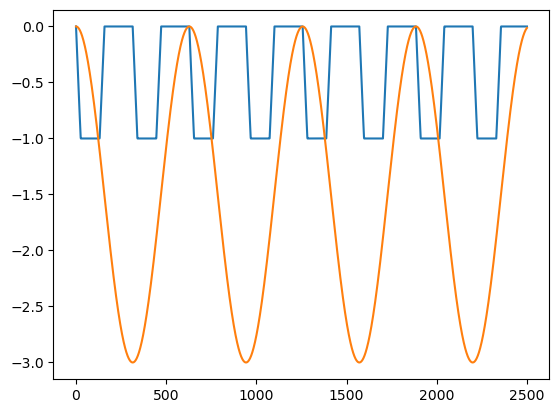

In [ ]:
time = np.linspace(0, SIM_TIME, int(SIM_TIME/DT))
u_z = -2 * np.sin(0.1 * time)
for step in range(time.size):
    if u_z[step] > 0:
        u_z[step] = 0
    elif u_z[step] < -1:
        u_z[step] = -1
    else:
        u_z[step] = u_z[step]
fig = plt.figure()
ax = plt.axes()

u_z1 = 1.5 * (np.cos(0.05 * time) -1)
ax.plot(u_z)
ax.plot(u_z1)
